In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import sys

In [2]:
from homework6 import *
from framework.dataset import create_dataset, collect_images_from_path

There are 222 images in the dataset.


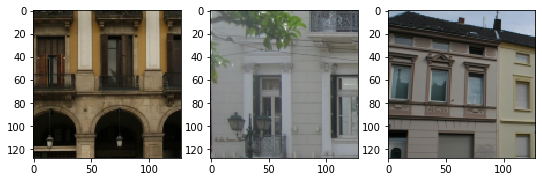

In [3]:
# Load all images
data_path = "../dataset/train/"
images = collect_images_from_path(data_path)

# Show some examples
fig = plt.figure(figsize=[9,3])
for idx, image in enumerate(images[:3]):
    fig.add_subplot(1,3,idx+1)
    plt.imshow(image)

In [4]:
images = collect_images_from_path(data_path)

There are 222 images in the dataset.


# Task 1 + 6: Try your crop function

In [5]:
# Create dataset using your crop function
dataset = create_dataset(
    data_path, 
    crop_image, # your crop function
    batch_size=20, 
    shuffle=True
)

There are 222 images in the dataset.


If your crop function works as expected you should see with the following cell your cropped input and the corresponding groundtruth.

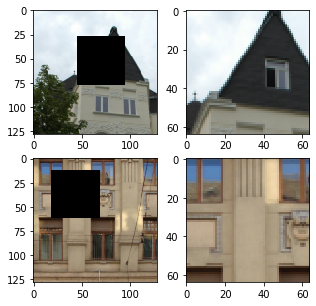

In [9]:
# Test your crop image function
for input_image, groundtruth_image in dataset:  
    fig = plt.figure(figsize=[5,5])
    
    fig.add_subplot(2, 2, 1)
    plt.imshow(input_image[0,...])
    
    fig.add_subplot(2, 2, 2)
    plt.imshow(groundtruth_image[0,...])
    
    fig.add_subplot(2, 2, 3)
    plt.imshow(input_image[1,...])
    
    fig.add_subplot(2, 2, 4)
    plt.imshow(groundtruth_image[1,...])
    
    break

# Task 3: Test your loss function

This is just to test if your loss function runs on tensorflow. This does not cover all the failure case, but if you obtain the same results, it should be good.

In [10]:
# Test your loss function (at least for bugs)
for input_image, groundtruth_image in dataset:
    loss_value = reconstruction_loss(groundtruth_image-1, groundtruth_image)
    print(loss_value.numpy())

1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999
1.0999999


# Task 4:  Test the reconstruction function

Using the cropped input image, and the corresponding groundtruth, you should be able to obtain the original image

In [11]:
model = Sequential()

# Encoder
model.add(Conv2D(64, kernel_size=4, strides=(2, 2), padding = 'same', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(64, kernel_size=4, strides=(2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(128, kernel_size=4, strides=(2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(256, kernel_size=4, strides=(2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(512, kernel_size=4, strides=(2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))

# Bottleneck
model.add(Conv2D(4000, kernel_size=4, strides=(1,1), padding = 'valid'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.5))

# Decoder
model.add(Conv2DTranspose(512, kernel_size=4, strides=(2, 2), padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(256, kernel_size=4, strides=(2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(128, kernel_size=4, strides=(2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(64, kernel_size=4, strides=(2, 2), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(3, kernel_size=4, strides=(2, 2), padding = 'same'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       1

In [13]:
def reconstruct_input_imagee(input_data, predicted_region):
    """
    Combines an input image (with a hole), and a (predicted) missing region
    to produce a full image.

    INPUT:
    - input_data: a numpy array of size (height, width, 3)
    - predicted_region: a numpy array of size (64, 64, 3)

    OUTPUT:
    - full_image: a numpy array of size (height, width, 3)
    """
    offset = 7

    h, w, _ = np.shape(predicted_region)

    mask = np.sum(input_data, axis=2) == 0
    mask_i = np.sum(mask, axis=0)
    mask_j = np.sum(mask, axis=1)
    
    #print(list(np.where(mask_i == 50)[0])[0])
    i = np.where(mask_i == 50)[0][0] - offset
    j = np.where(mask_j == 50)[0][0] - offset

    full_image = input_data.copy()
    full_image[j:j+h, i:i+w] = predicted_region

    return full_image

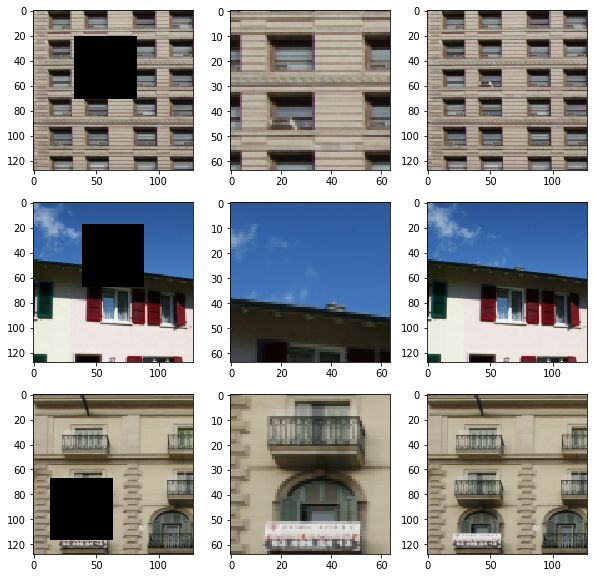

In [16]:
# Test your reconstruction function
for input_image, groundtruth_image in dataset:
    
    # Convert these tensors to numpy
    input_image = input_image.numpy() # size [batch_size, 128, 128, 3]
    groundtruth_image = groundtruth_image.numpy() # size [batch_size, 64, 64, 3]
    
    fig = plt.figure(figsize=[10,10])
    for i in range(3):
        # Reconstruct some images from the batch, using the groundtruth
        reconstruction = reconstruct_input_image(
            input_image[i,...], groundtruth_image[i,...]
        )

        # Plot the images
        fig.add_subplot(3, 3, 3*i + 1)
        plt.imshow(input_image[i,...])

        fig.add_subplot(3, 3, 3*i + 2)
        plt.imshow(groundtruth_image[i,...])

        fig.add_subplot(3, 3, 3*i + 3)
        plt.imshow(reconstruction)

    break